# Input to PU-Learn

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import gplately
import pandas as pd
from matplotlib.gridspec import GridSpec

import matplotlib
matplotlib.rcParams['font.family'] = 'Helvetica'
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams.update({
    "pdf.use14corefonts": True
})

%matplotlib inline

reconstruction_times = np.arange(0,171)

agegrid_dir = "/Users/ben/Dropbox/USyd/GPlates/"
agegrid_filename = agegrid_dir+"slab_dip/Clennet_AgeGrids_0.1d_masked/seafloor_age_mask_{:.1f}Ma.nc"



In [2]:
# Call GPlately's DataServer from the download.py module
gdownload = gplately.download.DataServer("Clennett2020")

# Obtain all rotation files, topology features and static polygons from Muller et al. 2019
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()

Checking whether the requested files need to be updated...
Requested files are up-to-date!


In [3]:
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

# Obtain geometry shapefiles with gdownload
coastlines, continents, COBs = gdownload.get_topology_geometries()

# Call the PlotTopologies object
time = 0 #Ma
gplot = gplately.PlotTopologies(model, coastlines, continents, COBs, time=time)

Checking whether the requested files need to be updated...
Requested files are up-to-date!


Read in `training_data.csv` from _stellar-data-mining_ GitHub repository. This CSV contains:

- Training data (from subduction zone kinematics and sampling magnetic, carbon grids, etc.)
- Test data (from Diaz-Rodgriguez et al. 2021 and Hoggard et al. 2020) - includes positive and negative labels
- Unlabelled data from random locations.

> Why are some data with from Diaz-Rodriguez or Hoggard marked as a training set?

In [4]:
df_training = pd.read_csv("../stellar-data-mining/prepared_data/training_data.csv")

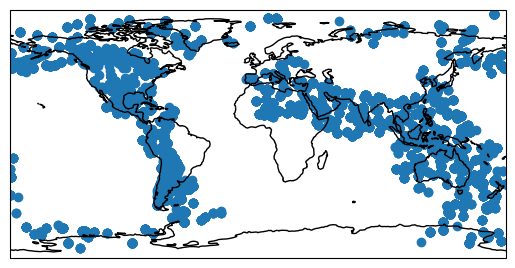

In [6]:
fig = plt.figure()
ax1 = fig.add_subplot(111, projection=ccrs.PlateCarree())
sc1 = ax1.scatter(df_training["lon"], df_training["lat"], transform=ccrs.PlateCarree())
ax1.coastlines()

Calculate distance to nearest fracture zone for each entry in the training dataset.

In [5]:
age_buffer = 10 # Ma

# initialise arrays for fracture zones, synthetic seamounts, LIP conjugates
fz_distances       = np.zeros((df_training.shape[0], age_buffer))
fz_magnitude       = np.zeros((df_training.shape[0], age_buffer))
seamount_distances = np.zeros((df_training.shape[0], age_buffer))
LIP_distances      = np.zeros((df_training.shape[0], age_buffer)) - 1
    
for a in range(0, age_buffer):
    ages  = np.clip(df_training['age (Ma)'] - a, 0, reconstruction_times.max()).astype(int)
    rlons = df_training['lon']
    rlats = df_training['lat']
        
    # find distance to fracture zones
    with np.load("subducted_fz_data.npz", "r") as npz:
        for i, age in enumerate(ages):
            # extract lon, lat, mag fracture zone data for a given age
            fz_data = npz[str(int(age))]
            fz_lons, fz_lats, fz_mag = fz_data
            if not fz_lons.any():
                continue

            # find distance between a reconstructed deposit and fracture zones
            dist = gplately.tools.haversine_distance(rlons[i], fz_lons,
                                                     rlats[i], fz_lats,
                                                     degrees=True)
            # find the minimum distance
            idx_dist = dist.argmin()
            fz_distances[i,a] = dist[idx_dist]*1e-3
            fz_magnitude[i,a] = fz_mag[idx_dist]

    # find distance to seamounts
    with np.load("subducted_synthetic_seamount_data.npz", "r") as npz:
        for i, age in enumerate(ages):
            # extract lon, lat, mag fracture zone data for a given age
            seamount_lons, seamount_lats = npz[str(int(age))]
            if not seamount_lons.any():
                continue


            # find distance between a reconstructed deposit and fracture zones
            dist = gplately.tools.haversine_distance(rlons[i], seamount_lons,
                                                     rlats[i], seamount_lats,
                                                     degrees=True)
            # find the minimum distance
            idx_dist = dist.argmin()
            seamount_distances[i,a] = dist[idx_dist]*1e-3

    # find distance to LIPs
    with np.load("subducted_LIP_data.npz", "r") as npz:
        for i, age in enumerate(ages):
            # extract lon, lat, mag fracture zone data for a given age
            LIP_lons, LIP_lats = npz[str(int(age))]
            if not LIP_lons.any():
                continue

            # find distance between a reconstructed deposit and fracture zones
            dist = gplately.tools.haversine_distance(rlons[i], LIP_lons,
                                                     rlats[i], LIP_lats,
                                                     degrees=True)
            # find the minimum distance
            idx_dist = dist.argmin()
            LIP_distances[i,a] = dist[idx_dist]*1e-3
        


idx_distances = fz_distances.argmin(axis=1)
rows = range(0, df_training.shape[0])
df_training = df_training.assign(fz_distance=fz_distances[rows,idx_distances])
df_training = df_training.assign(fz_magnitude=fz_magnitude[rows,idx_distances])
df_training = df_training.assign(seamount_distance=seamount_distances.min(axis=1))

LIP_distance = LIP_distances.min(axis=1)
LIP_distance[LIP_distance < 0] = np.nan # some LIP distances will be NaNs
df_training = df_training.assign(LIP_distance=LIP_distance)


Save to CSV

In [6]:
df_training.to_csv("../stellar-data-mining/prepared_data/training_data_fz_seamount_LIP.csv", index=False)

We have to do the same for `grid_points.csv.zip` which is a huge table of input variables gridded along subduction zones for every time step. Ideally Chris should save this as a numpy archive for each timestep, but never mind!

The tessellation threshold between subduction segments is likely different.

In [7]:
from scipy.spatial import cKDTree

def KD_dist(lons0, lats0, lons1, lats1):
    x0, y0, z0 = gplately.tools.lonlat2xyz(lons0, lats0)
    x1, y1, z1 = gplately.tools.lonlat2xyz(lons1, lats1)
    
    tree = cKDTree(np.c_[x0, y0, z0])
    d, idx = tree.query(np.c_[x1, y1, z1])
    return d*gplately.EARTH_RADIUS, idx

In [8]:
df_point_data = pd.read_csv("../stellar-data-mining/prepared_data/grid_data.csv.zip")

In [9]:
fz_point_distances       = np.zeros(df_point_data.shape[0])
fz_point_magnitudes      = np.zeros(df_point_data.shape[0])
seamount_point_distances = np.zeros(df_point_data.shape[0])
LIP_point_distances      = np.zeros(df_point_data.shape[0]) - 1

for time in reconstruction_times:
    mask_time = df_point_data['age (Ma)'] == time
    df_time = df_point_data[mask_time]
    
    # find distance to fracture zones
    with np.load("subducted_fz_data.npz", "r") as npz:
        # extract lon, lat, mag fracture zone data for a given age
        fz_lons, fz_lats, fz_mag = npz[str(int(time))]
        if not fz_lons.any():
            continue

        # find distance between a reconstructed deposit and fracture zones
        dist_fz, idx_fz = KD_dist(fz_lons, fz_lats, df_time['lon'], df_time['lat'])
        fz_point_distances[mask_time] = dist_fz
        fz_point_magnitudes[mask_time] = fz_mag[idx_fz]
        
    # find distance to seamounts
    with np.load("subducted_synthetic_seamount_data.npz", "r") as npz:
        # extract lon, lat, mag fracture zone data for a given age
        seamount_lons, seamount_lats = npz[str(int(time))]
        if not seamount_lons.any():
            continue
            
        dist_sm, idx_sm = KD_dist(seamount_lons, seamount_lats, df_time['lon'], df_time['lat'])
        seamount_point_distances[mask_time] = dist_sm
        
    # find distance to LIPs
    with np.load("subducted_LIP_data.npz", "r") as npz:
        # extract lon, lat, mag fracture zone data for a given age
        LIP_lons, LIP_lats = npz[str(int(time))]
        if not LIP_lons.any():
            continue

        dist_LIP, idx_LIP = KD_dist(LIP_lons, LIP_lats, df_time['lon'], df_time['lat'])
        LIP_point_distances[mask_time] = dist_LIP
        
df_point_data = df_point_data.assign(fz_distance=fz_point_distances)
df_point_data = df_point_data.assign(fz_magnitude=fz_point_magnitudes)
df_point_data = df_point_data.assign(seamount_distance=seamount_point_distances)

LIP_point_distances[LIP_point_distances < 0] = np.nan # some LIP distances will be NaNs
df_point_data = df_point_data.assign(LIP_distance=LIP_point_distances)

In [10]:
df_point_data.to_csv("../stellar-data-mining/prepared_data/grid_data_fz_seamount_LIP.csv.zip", index=False)

Create some CDF plots

In [11]:
def cdf_distance(dist, size):
    idx_sort = dist.argsort()
    dist = dist[idx_sort].copy()
    size = size[idx_sort].copy()
    size /= size.sum()
    cumsum_size = np.cumsum(size)
    return dist, cumsum_size

def mask_extent(lons, lats, extent):
    mask = np.logical_and(lons > extent[0], lons < extent[1])
    mask[lats < extent[2]] = False
    mask[lats > extent[3]] = False
    return mask

In [12]:
filter_americas = True

extent_americas = [-167, -23, -55, 85]
mask_americas = mask_extent(df_training['lon'], df_training['lat'], extent_americas)

347 7080
347 7080
347 7080


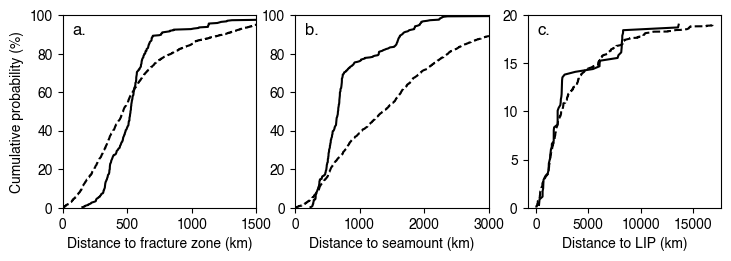

In [32]:
fig, axes = plt.subplots(1,3, figsize=(8.5,2.5))

# ax1.set_ylabel('Cumulative probability (%)')

for ax, feature in zip(axes, ['fz_distance', 'seamount_distance', 'LIP_distance']):
    dist_feat = df_training[df_training['label']=='positive'][feature].to_numpy()
    dist_rand = df_training[df_training['label']=='unlabelled'][feature].to_numpy()
    
    if filter_americas:
        dist_feat = dist_feat[mask_americas[df_training['label']=='positive']]
        dist_rand = dist_rand[mask_americas[df_training['label']=='unlabelled']]
    
    cumdist_feat, cumsize_feat = cdf_distance(dist_feat, np.ones_like(dist_feat))
    cumdist_rand, cumsize_rand = cdf_distance(dist_rand, np.ones_like(dist_rand))

    print(len(cumdist_feat), len(cumdist_rand))
    
    ax.plot(cumdist_feat, cumsize_feat*100, 'k', label='Porphyry copper deposits')
    ax.plot(cumdist_rand, cumsize_rand*100, 'k--', label='Random arc locations')
    ax.set_ylim(0,100)
    
axes[0].set_xlabel('Distance to fracture zone (km)')
axes[1].set_xlabel('Distance to seamount (km)')
axes[2].set_xlabel('Distance to LIP (km)')
axes[0].set_ylabel('Cumulative probability (%)')

axes[0].set_xlim(0,1500)
axes[1].set_xlim(0,3000)
axes[2].set_ylim(0,20)

axes[0].text(0.05, 0.9, 'a.', fontweight='bold', fontsize=12, transform=axes[0].transAxes)
axes[1].text(0.05, 0.9, 'b.', fontweight='bold', fontsize=12, transform=axes[1].transAxes)
axes[2].text(0.05, 0.9, 'c.', fontweight='bold', fontsize=12, transform=axes[2].transAxes)

fig.savefig("figures/cumulative_probability_fz_sm_LIP.png", bbox_inches='tight', dpi=300)
fig.savefig("figures/cumulative_probability_fz_sm_LIP.pdf", bbox_inches='tight', dpi=300)

In [13]:
def cdf_variable(variable):
    idx_sort = variable.argsort()
    X = variable[idx_sort]
    Y = np.linspace(0, 1, X.size)
    return X,Y

In [14]:
COLUMNS_TO_DROP = {
    "present_lon",
    "present_lat",
    "Cu (Mt)",
    "age (Ma)",
    "plate_id",
    "lon",
    "lat",
    "set",
    "source",
    "overriding_plate_id",
    "subducting_plate_ID",
    "trench_plate_ID",
    "arc_segment_length (degrees)",
    "trench_normal_angle (degrees)",
    "distance_from_trench_start (degrees)",
    "crustal_thickness_n",
    "magnetic_anomaly_n",
}

df_train = df_training.drop(columns=COLUMNS_TO_DROP, errors='ignore')

In [17]:
df_train.shape

(18335, 43)

In [15]:
ncols = 5
nrows = int(np.ceil(df_train.columns.size/5))

gs = GridSpec(nrows, ncols)

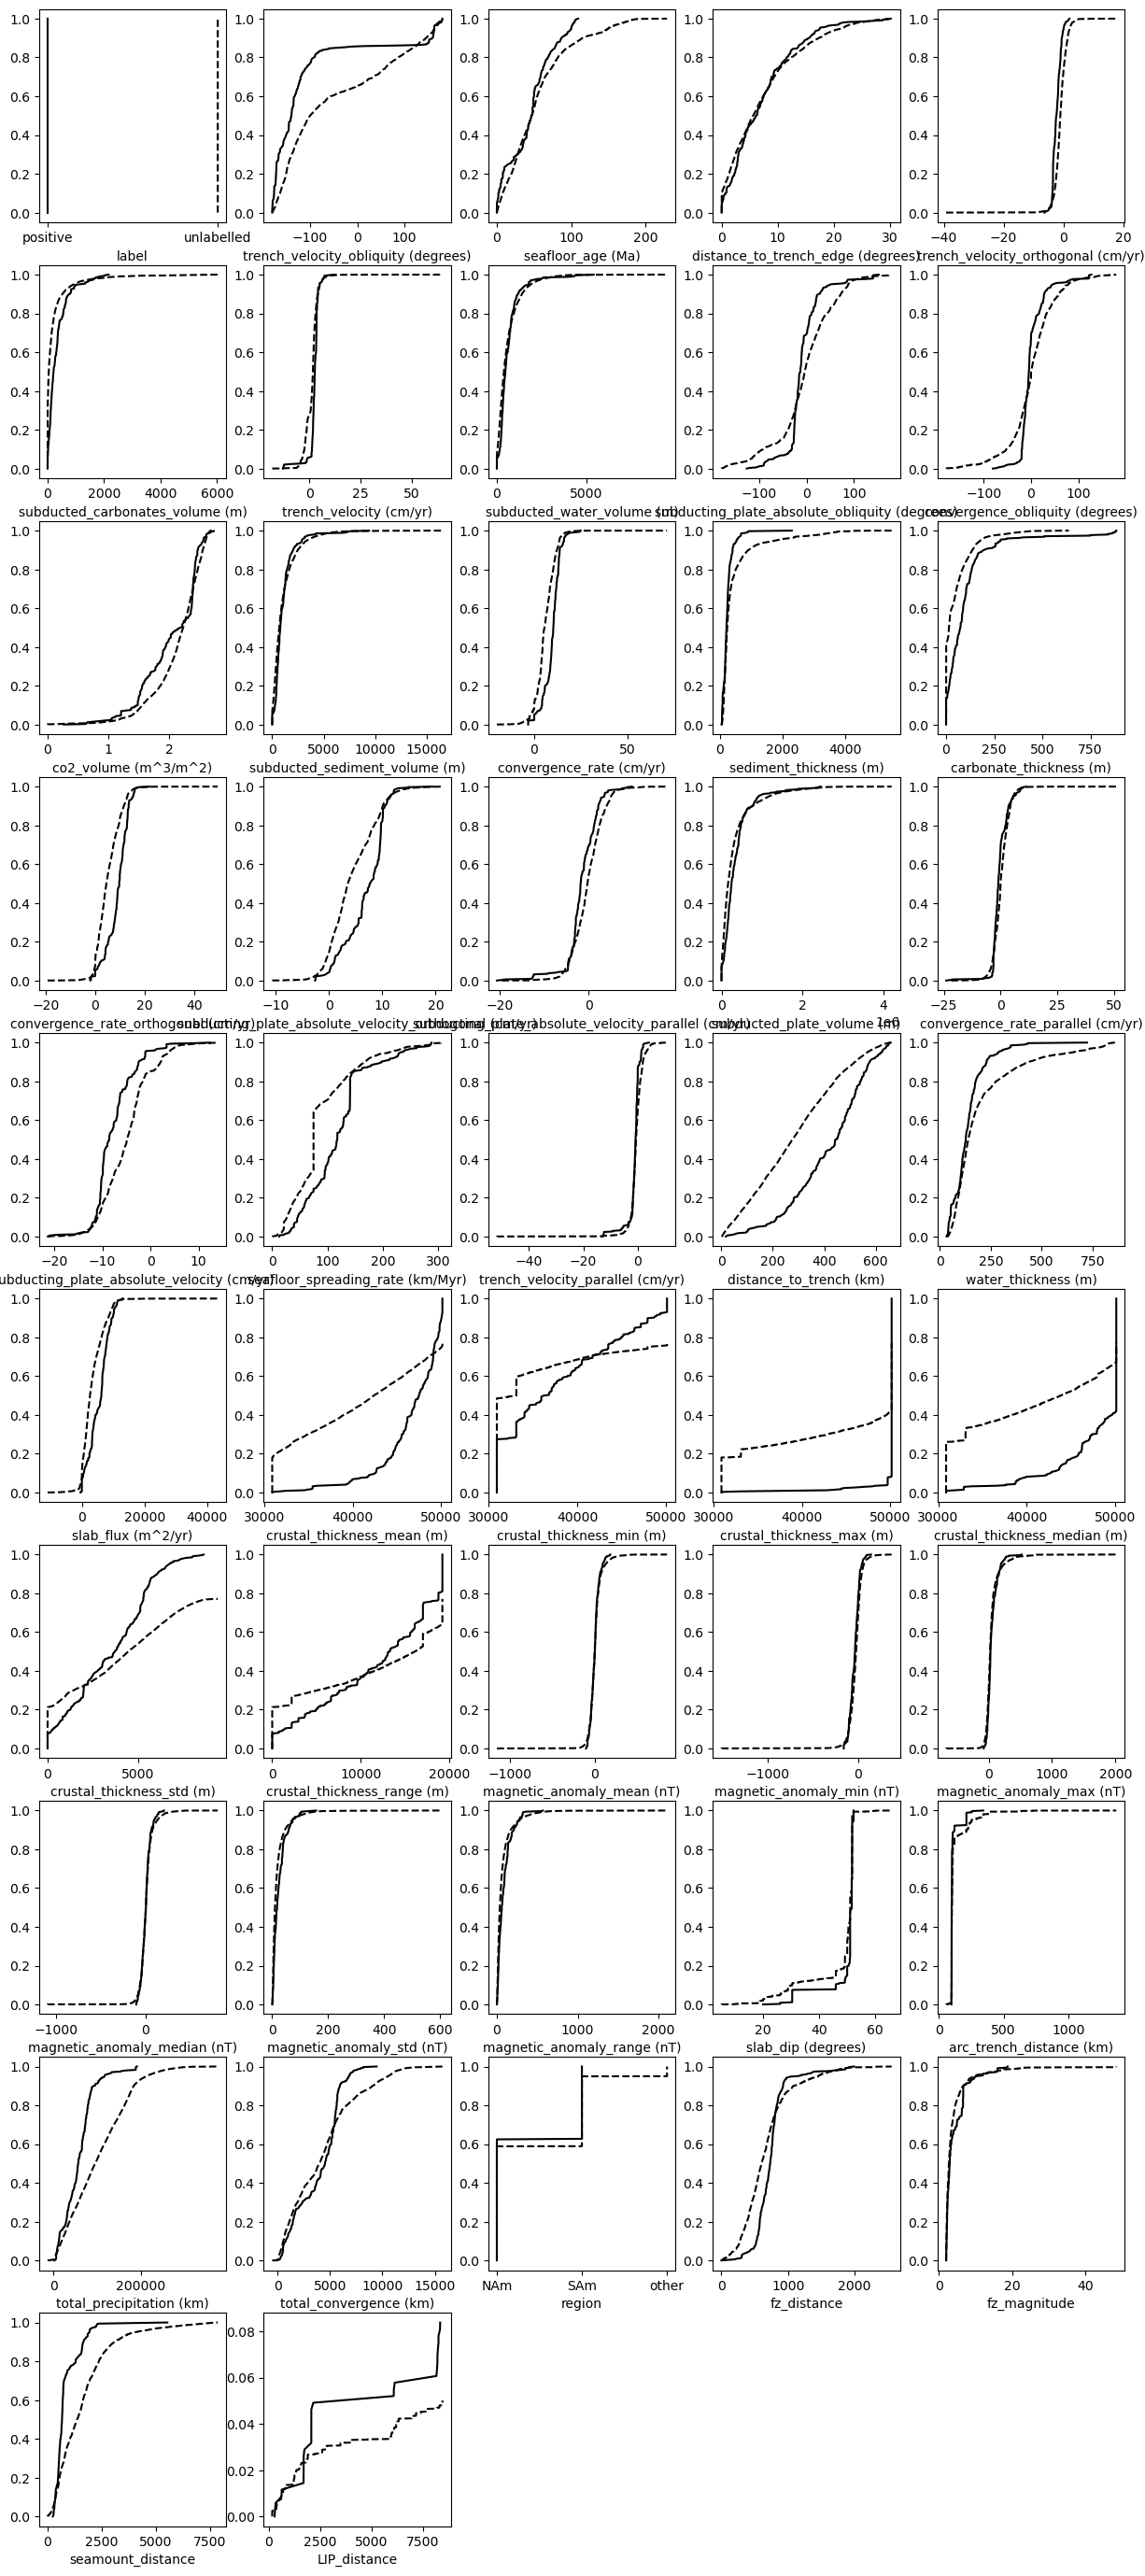

In [16]:
fig = plt.figure(figsize=(15,35))

index = 0

for row in range(0, nrows):
    for col in range(0, ncols):
        if index >= df_train.columns.size:
            break
        
        column = df_train.columns[index]
#         if column == 'label':
#             continue

        ax = fig.add_subplot(gs[row,col], xlabel=column)

        # create CDF
        var_positive  = df_train[df_train['label']=='positive'][column].to_numpy()
        var_unlabeled = df_train[df_train['label']=='unlabelled'][column].to_numpy()
        
        
        if filter_americas:
            var_positive  = var_positive[mask_americas[df_training['label']=='positive']]
            var_unlabeled = var_unlabeled[mask_americas[df_training['label']=='unlabelled']]
            
        x_positive, y_positive   =  cdf_variable(var_positive)
        x_unlabeled, y_unlabeled =  cdf_variable(var_unlabeled)
        
        ax.plot(x_positive, y_positive, 'k')
        ax.plot(x_unlabeled, y_unlabeled, 'k--')

        index += 1

plt.show()

Just plot CDFs for quantities of interest